In [1]:
 pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 41.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 43.3 MB/s eta 0:00:00


In [2]:
#Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS
import sklearn.model_selection as ms
import sklearn.preprocessing as p
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import transformers as trfs
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [3]:
#Loading data
from google.colab import files
files.upload()
data = pd.read_csv("chatgpt-reddit-comments.csv", index_col='Unnamed: 0')


Saving chatgpt-reddit-comments.csv to chatgpt-reddit-comments.csv


In [4]:
data.head()

,comment_id,comment_parent_id,comment_body,subreddit
0,iztdxuh,t3_zj2aeu,"I've been shocked for days now, I don't need c...",r/ChatGPT
1,iztn0q0,t3_zj2aeu,\n\nI am so angry right now. I just wasted my...,r/ChatGPT
2,izudrph,t3_zj2aeu,chatgpt karma whoring is here folks! just when...,r/ChatGPT
3,iztfhtb,t3_zj2aeu,"Worked on me, ngl.",r/ChatGPT
4,izu2as9,t3_zj2aeu,"Certified 10/10, must-see moment. It really di...",r/ChatGPT


In [5]:
#Checking data shape
data.shape

(52416, 4)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52416 entries, 0 to 
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   comment_id         52415 non-null  object
 1   comment_parent_id  52415 non-null  object
 2   comment_body       52415 non-null  object
 3   subreddit          52415 non-null  object
dtypes: object(4)
memory usage: 2.0+ MB


In [7]:
data.isnull().sum()

comment_id           1
comment_parent_id    1
comment_body         1
subreddit            1
dtype: int64

In [8]:
data.dropna(inplace = True)
data.isna().sum()

comment_id           0
comment_parent_id    0
comment_body         0
subreddit            0
dtype: int64

In [9]:
subreddit_count = data['subreddit'].value_counts()
subreddit_count

r/ChatGPT            29711
r/technology         16672
r/Futurology          5009
r/dataisbeautiful     1020
subreddit                3
Name: subreddit, dtype: int64

In [10]:
parent_comment = data['comment_parent_id'].value_counts()
parent_comment

t3_107vs7i    239
t3_109g9gf    223
t3_10mias6    216
t3_10heg9p    208
t3_ztd950     202
             ... 
t1_j59syw8      1
t1_j59o2s4      1
t1_j59y2i8      1
t1_j5dhf8u      1
t1_j5m6aj0      1
Name: comment_parent_id, Length: 22596, dtype: int64

Text(0.5, 1.0, 'Comment Frequency by Subreddits')

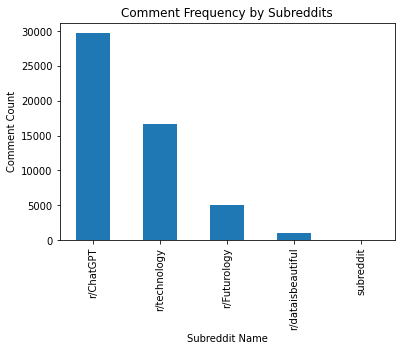

In [11]:
subreddit_count.plot(kind='bar')
plt.xlabel("Subreddit Name")
plt.ylabel("Comment Count")
plt.title("Comment Frequency by Subreddits")

In [12]:
data.comment_body[15]

'Shit it worked on me'

# Plotting WordCloud

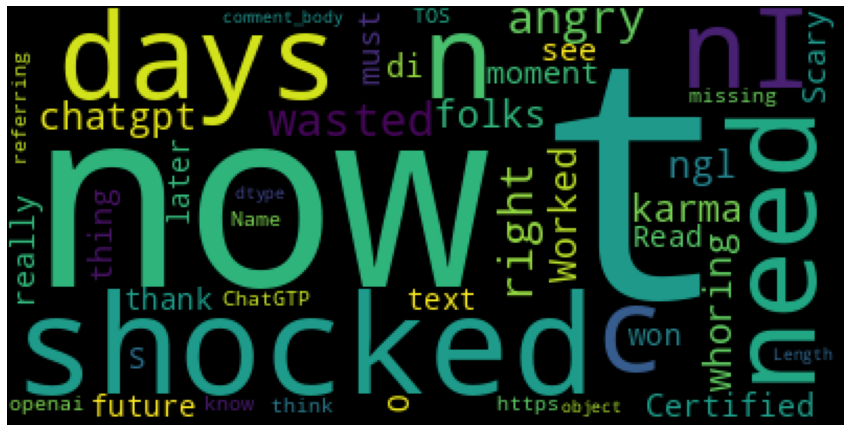

In [13]:
cloud = WordCloud(stopwords=STOPWORDS, background_color='black', max_words=200).generate(str(data.comment_body))
plt.figure(figsize=(15,10))
plt.clf
plt.imshow(cloud)
plt.axis('off')
plt.show()

# Applying VADER

In [14]:
sid = SentimentIntensityAnalyzer()

In [15]:
data['scores'] = data['comment_body'].apply(lambda comment_body: sid.polarity_scores(comment_body))
data.head()

,comment_id,comment_parent_id,comment_body,subreddit,scores
0,iztdxuh,t3_zj2aeu,"I've been shocked for days now, I don't need c...",r/ChatGPT,"{'neg': 0.223, 'neu': 0.777, 'pos': 0.0, 'comp..."
1,iztn0q0,t3_zj2aeu,\n\nI am so angry right now. I just wasted my...,r/ChatGPT,"{'neg': 0.201, 'neu': 0.734, 'pos': 0.065, 'co..."
2,izudrph,t3_zj2aeu,chatgpt karma whoring is here folks! just when...,r/ChatGPT,"{'neg': 0.151, 'neu': 0.725, 'pos': 0.124, 'co..."
3,iztfhtb,t3_zj2aeu,"Worked on me, ngl.",r/ChatGPT,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
4,izu2as9,t3_zj2aeu,"Certified 10/10, must-see moment. It really di...",r/ChatGPT,"{'neg': 0.207, 'neu': 0.793, 'pos': 0.0, 'comp..."


In [16]:
data['compound']  = data['scores'].apply(lambda score_dict: score_dict['compound'])
data.head()

,comment_id,comment_parent_id,comment_body,subreddit,scores,compound
0,iztdxuh,t3_zj2aeu,"I've been shocked for days now, I don't need c...",r/ChatGPT,"{'neg': 0.223, 'neu': 0.777, 'pos': 0.0, 'comp...",-0.3182
1,iztn0q0,t3_zj2aeu,\n\nI am so angry right now. I just wasted my...,r/ChatGPT,"{'neg': 0.201, 'neu': 0.734, 'pos': 0.065, 'co...",-0.9837
2,izudrph,t3_zj2aeu,chatgpt karma whoring is here folks! just when...,r/ChatGPT,"{'neg': 0.151, 'neu': 0.725, 'pos': 0.124, 'co...",-0.2001
3,iztfhtb,t3_zj2aeu,"Worked on me, ngl.",r/ChatGPT,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
4,izu2as9,t3_zj2aeu,"Certified 10/10, must-see moment. It really di...",r/ChatGPT,"{'neg': 0.207, 'neu': 0.793, 'pos': 0.0, 'comp...",-0.4364


In [17]:
# Function to label the sentiment according to score
def get_tag(val):
    if val <= -0.50:
        return "Negative"
    elif val >= 0.5:
        return "Positive"
    else:
        return "Neutral"

In [18]:
data['Sentiment'] = data['compound'].apply(get_tag)
data.head()

,comment_id,comment_parent_id,comment_body,subreddit,scores,compound,Sentiment
0,iztdxuh,t3_zj2aeu,"I've been shocked for days now, I don't need c...",r/ChatGPT,"{'neg': 0.223, 'neu': 0.777, 'pos': 0.0, 'comp...",-0.3182,Neutral
1,iztn0q0,t3_zj2aeu,\n\nI am so angry right now. I just wasted my...,r/ChatGPT,"{'neg': 0.201, 'neu': 0.734, 'pos': 0.065, 'co...",-0.9837,Negative
2,izudrph,t3_zj2aeu,chatgpt karma whoring is here folks! just when...,r/ChatGPT,"{'neg': 0.151, 'neu': 0.725, 'pos': 0.124, 'co...",-0.2001,Neutral
3,iztfhtb,t3_zj2aeu,"Worked on me, ngl.",r/ChatGPT,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral
4,izu2as9,t3_zj2aeu,"Certified 10/10, must-see moment. It really di...",r/ChatGPT,"{'neg': 0.207, 'neu': 0.793, 'pos': 0.0, 'comp...",-0.4364,Neutral


In [19]:
data.drop(['scores', 'compound'], axis=1, inplace=True)

In [20]:
data.head(10)

,comment_id,comment_parent_id,comment_body,subreddit,Sentiment
0,iztdxuh,t3_zj2aeu,"I've been shocked for days now, I don't need c...",r/ChatGPT,Neutral
1,iztn0q0,t3_zj2aeu,\n\nI am so angry right now. I just wasted my...,r/ChatGPT,Negative
2,izudrph,t3_zj2aeu,chatgpt karma whoring is here folks! just when...,r/ChatGPT,Neutral
3,iztfhtb,t3_zj2aeu,"Worked on me, ngl.",r/ChatGPT,Neutral
4,izu2as9,t3_zj2aeu,"Certified 10/10, must-see moment. It really di...",r/ChatGPT,Neutral
5,izw8iw3,t3_zj2aeu,"Wow, way to discover the most basic functional...",r/ChatGPT,Positive
6,izvxxi8,t3_zj2aeu,"People on Reddit seek the karma and the fame,\...",r/ChatGPT,Positive
7,izwe6c7,t3_zj2aeu,Inception)),r/ChatGPT,Neutral
8,iztipoe,t3_zj2aeu,What's the point of even trying to click-bait ...,r/ChatGPT,Neutral
9,izvxsd9,t3_zj2aeu,I love you.,r/ChatGPT,Positive


In [21]:
sentiment = data['Sentiment'].value_counts()
sentiment

Neutral     32134
Positive    14461
Negative     5820
Name: Sentiment, dtype: int64

Text(0.5, 1.0, 'Sentment Frequenecy')

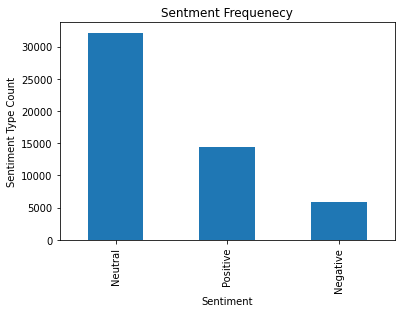

In [22]:
sentiment.plot(kind='bar')
plt.xlabel("Sentiment")
plt.ylabel("Sentiment Type Count")
plt.title("Sentment Frequenecy")

# Replacing Sentiment labels with integers for processing

In [23]:
data.to_csv('Labeled Data.csv')

data_labeled = pd.read_csv('Labeled Data.csv')
data_labeled['Sentment'] = data_labeled['Sentiment'].replace(['Negative', 'Positive', 'Neutral'], [-1, 1, 0], inplace=True)

# Initializing the BERT model for Training

In [24]:
# Max length of encoded string(including special tokens such as [CLS] and [SEP]):
MAX_SEQUENCE_LENGTH = 64

# Standard BERT model with lowercase chars only:
PRETRAINED_MODEL_NAME = 'bert-base-uncased' 

# Batch size for fitting:
BATCH_SIZE = 128

# Number of epochs:
EPOCHS=4

In [25]:
# Creating a function for BERT model building
def create_model(max_sequence, model_name, num_labels):
    bert_model = trfs.TFBertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
    
    input_ids = tf.keras.layers.Input(shape=(max_sequence,), dtype=tf.int32, name='input_ids')

    attention_mask = tf.keras.layers.Input((max_sequence,), dtype=tf.int32, name='attention_mask')
    
    output = bert_model([input_ids, attention_mask])[0]

    output = tf.keras.layers.Dense(num_labels, activation='softmax')(output)

    model = tf.keras.models.Model(inputs=[input_ids, attention_mask], outputs=output)
    return model

In [26]:
model = create_model(MAX_SEQUENCE_LENGTH, PRETRAINED_MODEL_NAME, 3)

opt = tf.keras.optimizers.Adam(learning_rate=3e-5)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
def batch_encode(X, tokenizer):
    return tokenizer.batch_encode_plus(
    X,
    max_length=MAX_SEQUENCE_LENGTH, # set the length of the sequences
    add_special_tokens=True, # add [CLS] and [SEP] tokens
    return_attention_mask=True,
    return_token_type_ids=False, # not needed for this type of ML task
    pad_to_max_length=True, # add 0 pad tokens to the sequences less than max_length
    return_tensors='tf'
)

In [28]:
tokenizer = trfs.BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)

In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 64)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 64)]         0           []                               
                                                                                                  
 tf_bert_for_sequence_classific  TFSequenceClassifie  109484547  ['input_ids[0][0]',              
 ation (TFBertForSequenceClassi  rOutput(loss=None,               'attention_mask[0][0]']         
 fication)                      logits=(None, 3),                                                 
                                 hidden_states=None                                           

# Splitting the data between train and test

In [30]:
X_train, X_val, y_train, y_val = ms.train_test_split(data_labeled.comment_body.values, data_labeled.Sentiment.values, test_size=0.2)

In [31]:
y_train

array([ 0,  0,  0, ...,  1,  0, -1])

In [32]:
y_train = to_categorical(y_train, 3)
y_val = to_categorical(y_val, 3)

In [33]:
X_train = batch_encode(X_train, tokenizer)
X_val = batch_encode(X_val, tokenizer)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [34]:
history = model.fit(
    x=X_train.values(),
    y=y_train,
    validation_data=(X_val.values(), y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

Epoch 1/4
328/328 [==============================] - 605s 2s/step - loss: 0.6111 - accuracy: 0.7442 - precision: 0.7878 - recall: 0.6710 - val_loss: 0.4686 - val_accuracy: 0.8043 - val_precision: 0.8312 - val_recall: 0.7752
Epoch 2/4
328/328 [==============================] - 562s 2s/step - loss: 0.3840 - accuracy: 0.8437 - precision: 0.8648 - recall: 0.8215 - val_loss: 0.4018 - val_accuracy: 0.8290 - val_precision: 0.8709 - val_recall: 0.7825
Epoch 3/4
328/328 [==============================] - 562s 2s/step - loss: 0.2898 - accuracy: 0.8849 - precision: 0.9009 - recall: 0.8696 - val_loss: 0.4146 - val_accuracy: 0.8288 - val_precision: 0.8471 - val_recall: 0.8115
Epoch 4/4
328/328 [==============================] - 562s 2s/step - loss: 0.2132 - accuracy: 0.9191 - precision: 0.9294 - recall: 0.9087 - val_loss: 0.4470 - val_accuracy: 0.8295 - val_precision: 0.8505 - val_recall: 0.8117


# Plotting Model Accuracy, Loss, Precision and Recall

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


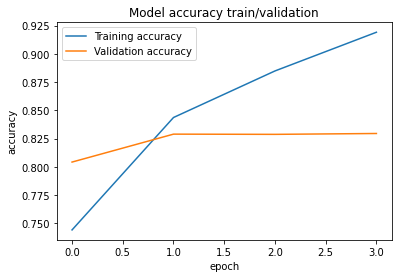

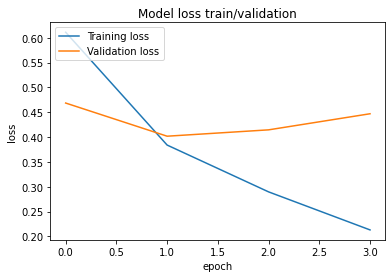

In [35]:
# list the metrics names used during training/validation
print(history.history.keys())

# Plotting model accuracy for both training and validation
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy train/validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training accuracy', 'Validation accuracy'], loc='upper left')
plt.show()


# Plotting model loss for both training and validation
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss train/validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training loss', 'Validation loss'], loc='upper left')
plt.show()

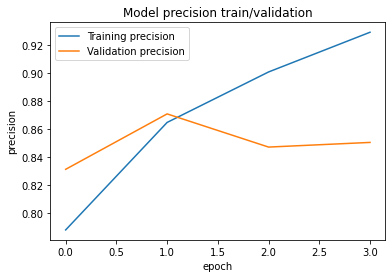

In [36]:
# Plotting model precision for both training and validation
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model precision train/validation')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['Training precision', 'Validation precision'], loc='upper left')
plt.show()

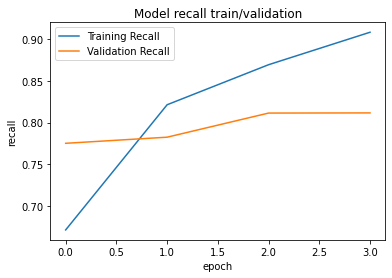

In [37]:
# Plotting model precision for both training and validation
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model recall train/validation')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['Training Recall', 'Validation Recall'], loc='upper left')
plt.show()

In [38]:
y_pred = model.predict(X_val.values())

328/328 [==============================] - 49s 141ms/step


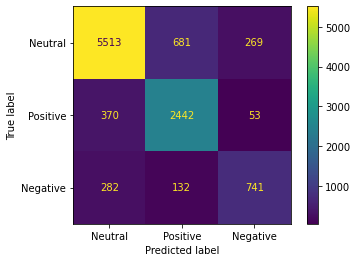

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = np.argmax(y_pred, axis=1)
y_val = np.argmax(y_val, axis=1)
matrix = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(matrix, display_labels = ['Neutral', 'Positive', 'Negative'])
disp.plot()


# References
https://datafai.com/simple-wordcloud-using-nltk-library-in-python/

https://github.com/cjhutto/vaderSentiment

https://arxiv.org/abs/1810.04805

https://huggingface.co/bert-base-uncased

https://stackoverflow.com/questions/60463829/training-tfbertforsequenceclassification-with-custom-x-and-y-data

https://www.kaggle.com/code/prakharrathi25/sentiment-analysis-using-bert

https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
